# AUPIMO

Advance use cases of the metric AUPIMO (pronounced "a-u-pee-mo").

> For basic usage, please check the notebook [701a_aupimo.ipynb](./701a_aupimo.ipynb).

Includes:
- selection of test representative samples for qualitative analysis
- visualization of the AUPIMO metric with heatmaps


# What is AUPIMO?

The `Area Under the Per-Image Overlap [curve]` (AUPIMO) is a metric of recall (higher is better) designed for visual anomaly detection.

Inspired by the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and [PRO](https://link.springer.com/article/10.1007/s11263-020-01400-4) curves, 

> AUPIMO is the area under a curve of True Positive Rate (TPR or _recall_) as a function of False Positive Rate (FPR) restricted to a fixed range. 

But:
- the TPR (Y-axis) is *per-image* (1 image = 1 curve/score);
- the FPR (X-axis) considers the (average of) **normal** images only; 
- the FPR (X-axis) is in log scale and its range is [1e-5, 1e-4]\* (harder detection task!).

\* The score (the area under the curve) is normalized to be in [0, 1].

AUPIMO can be interpreted as

> average segmentation recall in an image given that the model (nearly) does not yield false positives in normal images.

References in the last cell.

![AUROC vs. AUPRO vs. AUPIMO](./roc_pro_pimo.svg)

# Setup

Install `anomalib` using `pip`.

In [ ]:
# TODO(jpcbertoldo): replace by `pip install anomalib` when AUPIMO is released  # noqa: TD003
%pip install ../..

Change the directory to have access to the datasets.

In [2]:
from pathlib import Path

# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = Path.cwd().parent.parent / "datasets" / "MVTec"

Imports

In [ ]:
import cv2
import matplotlib as mpl
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy import stats

from anomalib import TaskType
from anomalib.data import MVTec
from anomalib.data.utils import read_image
from anomalib.engine import Engine
from anomalib.metrics import AUPIMO
from anomalib.models import Padim

In [4]:
%matplotlib inline

In [5]:
pd.set_option("display.float_format", "{:.2f}".format)

# Basics

This part was covered in the notebook [701a_aupimo.ipynb](701a_aupimo.ipynb), so we'll not discuss it here.

It will train a model and evaluate it using AUPIMO.
We will use dataset Leather from MVTec AD with `PaDiM` (performance is not the best, but it is fast to train).

> See the notebooks below for more details on:
> - datamodules: [100_datamodules]((https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/100_datamodules));
> - models: [200_models](https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/200_models).

In [ ]:
# train the model
task = TaskType.SEGMENTATION
datamodule = MVTec(
    root=dataset_root,
    category="leather",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=8,
    task=task,
)
model = Padim(
    # only use one layer to speed it up
    layers=["layer1"],
    n_features=64,
    backbone="resnet18",
    pre_trained=True,
)
engine = Engine(
    pixel_metrics="AUPIMO",  # others can be added
    accelerator="auto",  # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
    devices=1,
    logger=False,
)
engine.fit(datamodule=datamodule, model=model)
# infer
predictions = engine.predict(dataloaders=datamodule.test_dataloader(), model=model, return_predictions=True)

Compute AUPIMO

In [7]:
aupimo = AUPIMO(
    # with `False` all the values are returned in a dataclass
    return_average=False,
)

anomaly_maps = []
masks = []
labels = []
image_paths = []
for batch in predictions:
    anomaly_maps.append(batch_anomaly_maps := batch["anomaly_maps"].squeeze(dim=1))
    masks.append(batch_masks := batch["mask"])
    labels.append(batch["label"])
    image_paths.append(batch["image_path"])
    aupimo.update(anomaly_maps=batch_anomaly_maps, masks=batch_masks)

# list[list[str]] -> list[str]
image_paths = [item for sublist in image_paths for item in sublist]
anomaly_maps = torch.cat(anomaly_maps, dim=0)
masks = torch.cat(masks, dim=0)
labels = torch.cat(labels, dim=0)

# `pimo_result` has the PIMO curves of each image
# `aupimo_result` has the AUPIMO values
#     i.e. their Area Under the Curve (AUC)
pimo_result, aupimo_result = aupimo.compute()

Metric `AUPIMO` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.


Statistics and score distribution.

MEAN
aupimo_result.aupimos[labels == 1].mean().item()=0.742841961578308
OTHER STATISTICS
DescribeResult(nobs=92, minmax=(0.0, 1.0), mean=0.742841961578308, variance=0.08757792704451817, skewness=-0.9285678601866055, kurtosis=-0.3299211772047075)


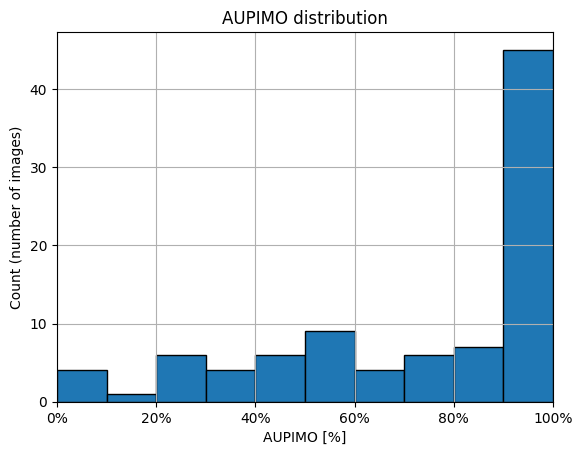

In [8]:
# the normal images have `nan` values because
# recall is not defined for them so we ignore them
print(f"MEAN\n{aupimo_result.aupimos[labels == 1].mean().item()=}")
print(f"OTHER STATISTICS\n{stats.describe(aupimo_result.aupimos[labels == 1])}")

fig, ax = plt.subplots()
ax.hist(aupimo_result.aupimos[labels == 1].numpy(), bins=np.linspace(0, 1, 11), edgecolor="black")
ax.set_ylabel("Count (number of images)")
ax.set_xlim(0, 1)
ax.set_xlabel("AUPIMO [%]")
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.grid()
ax.set_title("AUPIMO distribution")
fig  # noqa: B018, RUF100

Until here we just reproduded the notebook with the basic usage of AUPIMO.

# Selecting Representative Samples for Qualitative Analysis

Instead of cherry picking or inspecting the 92 samples from above, we'll try to choose them smartly.

Our goal here is to select a handful of samples in a meaningful way.

> Notice that a random selection from the distribution above would probably miss the worst cases.

We will summarize this distribution with a boxplot, then select the samples corresponding to the statistics in it.

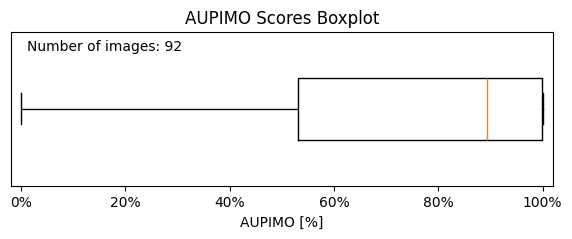

In [9]:
fig, ax = plt.subplots(figsize=(7, 2))
boxplot_data = ax.boxplot(
    aupimo_result.aupimos[labels == 1].numpy(),
    vert=False,
    widths=0.4,
)
_ = ax.set_yticks([])
ax.set_xlim(0 - (eps := 2e-2), 1 + eps)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("AUPIMO [%]")
ax.set_title("AUPIMO Scores Boxplot")
num_images = (labels == 1).sum().item()
ax.annotate(
    text=f"Number of images: {num_images}",
    xy=(0.03, 0.95),
    xycoords="axes fraction",
    xytext=(0, 0),
    textcoords="offset points",
    annotation_clip=False,
    verticalalignment="top",
)
fig  # noqa: B018, RUF100

To get the values in the boxplot (e.g., whiskers, quartiles, etc.), we're going to use `matplotlib`'s internal function `mpl.cbook.boxplot_stats()`.

In [10]:
boxplot_data = mpl.cbook.boxplot_stats(aupimo_result.aupimos[labels == 1].numpy())[0]
print(boxplot_data.keys())

dict_keys(['mean', 'iqr', 'cilo', 'cihi', 'whishi', 'whislo', 'fliers', 'q1', 'med', 'q3'])


We'll select 5 of those and find images in the dataset that match them.

In [11]:
image_selection = []

for key in ["whislo", "q1", "med", "q3", "whishi"]:
    value = boxplot_data[key]
    # find the image that is closest to the value of the statistic
    #     `[labels == 1]` is not used here so that the image's
    #         indexes are the same as the ones in the dataset
    #     we use `sort()` -- instead of `argmin()` -- so that
    #         the `nan`s are not considered (they are at the end)
    closest_image_index = (aupimo_result.aupimos - value).abs().argsort()[0]
    image_selection.append({"statistic": key, "value": value, "image_index": closest_image_index.item()})

image_selection = pd.DataFrame(image_selection)
print(image_selection)

  statistic  value  image_index
0    whislo   0.00           65
1        q1   0.53           58
2       med   0.89           63
3        q3   1.00           22
4    whishi   1.00            0


Notice that they are sorted from the worst to the best AUPIMO score.

# Visualizing the Representative Samples

Let's visualize what the heatmaps of these samples.

In [12]:
# will be used to normalize the anomaly maps to fit a colormap
global_vmin, global_vmax = torch.quantile(anomaly_maps, torch.tensor([0.02, 0.98]))

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(16, 7), layout="constrained")

for ax_column, (_, row) in zip(axes.T, image_selection.iterrows(), strict=False):
    ax_above, ax_below = ax_column
    image = cv2.resize(read_image(image_paths[row.image_index]), (256, 256))
    anomaly_map = anomaly_maps[row.image_index].numpy()
    mask = masks[row.image_index].squeeze().numpy()
    ax_above.imshow(image)
    ax_above.contour(mask, levels=[0.5], colors="magenta", linewidths=1)
    ax_below.imshow(image)
    ax_below.imshow(anomaly_map, cmap="jet", vmin=global_vmin, vmax=global_vmax, alpha=0.30)
    ax_below.contour(mask, levels=[0.5], colors="magenta", linewidths=1)
    ax_above.set_title(f"{row.statistic}: {row.value:.0%} AUPIMO  image {row.image_index}")

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

axes[0, 0].set_ylabel("Image + GT Mask")
axes[1, 0].set_ylabel("Image + GT Mask + Anomaly Map")
fig.text(
    0.03,
    -0.01,
    "Magenta: contours of the ground truth (GT) mask. "
    "Anomaly maps colored in JET colormap with global (across all images) min-max normalization.",
    ha="left",
    va="top",
    fontsize="small",
    color="dimgray",
)

fig.suptitle("Anomalous samples from AUPIMO boxplot's statistics")
fig  # noqa: B018, RUF100

The heatmaps give the impression that all samples are properly detected, right?

Notice that the lowest AUPIMO (left) is 0, but the heatmap is (contradictorily) showing a good detection.

Why is that?

These heatmaps are colored with a gradient from the minimum to the maximum value in all the heatmaps from the test set.

This is not taking into account the contraints (FPR restriction) in AUPIMO.

Let's compare with the heatmaps from some normal images.

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(16, 7), layout="constrained")

# random selection of normal images
rng = np.random.default_rng(42)
normal_images_selection = rng.choice(np.where(labels == 0)[0], size=5, replace=False)

for ax_column, index in zip(axes.T, normal_images_selection, strict=False):
    ax_above, ax_below = ax_column
    image = cv2.resize(read_image(image_paths[index]), (256, 256))
    anomaly_map = anomaly_maps[index].numpy()
    ax_above.imshow(image)
    ax_below.imshow(image)
    ax_below.imshow(anomaly_map, cmap="jet", vmin=global_vmin, vmax=global_vmax, alpha=0.30)
    ax_above.set_title(f"image {index}")

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

axes[0, 0].set_ylabel("Image")
axes[1, 0].set_ylabel("Image + Anomaly Map")
fig.text(
    0.03,
    -0.01,
    "Anomaly maps colored in JET colormap with global (across all images) min-max normalization.",
    ha="left",
    va="top",
    fontsize="small",
    color="dimgray",
)

fig.suptitle("Normal samples (test set)")
fig  # noqa: B018, RUF100

Notice how the normal images also have high anomaly scores ("hot" colors) although there is no anomaly.

As a matter of fact, the heatmaps can barely differentiate between some normal and anomalous images.

See the two heatmaps below for instance.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4), layout="constrained")

for ax, index in zip(axes.flatten(), [87, 65], strict=False):
    image = cv2.resize(read_image(image_paths[index]), (256, 256))
    anomaly_map = anomaly_maps[index].numpy()
    mask = masks[index].squeeze().numpy()
    ax.imshow(image)
    ax.contour(mask, levels=[0.5], colors="magenta", linewidths=1)
    ax.imshow(anomaly_map, cmap="jet", vmin=global_vmin, vmax=global_vmax, alpha=0.30)
    ax.set_title(f"image {index}")

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

axes[0].set_title(f"{axes[0].get_title()} (normal)")
axes[1].set_title(f"{axes[1].get_title()} (anomalous)")

fig.text(
    0.03,
    -0.01,
    "Magenta: contours of the ground truth (GT) mask.\n"
    "Anomaly maps colored in JET colormap with global (across all images) min-max normalization.",
    ha="left",
    va="top",
    fontsize="small",
    color="dimgray",
)

fig.suptitle("Normal vs. Anomalous Samples")
fig  # noqa: B018, RUF100

One would expect image 65 (anomalous) to a 'hotter' heatmap than image 87 (normal), but it is the opposite.

This shows that the model is not doing a great job.

# Visualizing the AUPIMO on the Heatmaps

We will create another visualization to link the heatmaps to AUPIMO.

Recall that AUPIMO computes this integral (simplified):

$$
    \int_{\log(L)}^{\log(U)} 
    \operatorname{TPR}^{i}\left( \operatorname{FRP^{-1}}( z ) \right)
    \, 
    \mathrm{d}\log(z)   
$$

The integration bounds -- $L$[ower] and $U$[pper] -- are FPR values.

> More details about their meaning in the next notebook.

We will leverage these two bounds to create a heatmap that shows them in a gradient like this:

![Visualization of AUPIMO on the heatmaps](./pimo_viz.svg)

If the anomaly score is
1. too low (below the lowest threshold of AUPIMO) $\rightarrow$ not shown; 
2. between the bounds $\rightarrow$ shown in a JET gradient;
3. too high (above the highest threshold of AUPIMO) $\rightarrow$ shown in a single color.

> Technical detail: lower/upper bound of FPR correspond to the upper/lower bound of threshold.

> **Why low values are not shown?**
>
> Because the values below the lower (threshold) bound would  _never_  be seen as "anomalous" by the metric.
>
> Analogously, high values are shown in red because they are  _always_  seen as "anomalous" by the metric.

In [16]:
# the fpr bounds are fixed in advance in the metric object
print(f"""FPR bounds
Lower bound: {aupimo.fpr_bounds[0]:.5f}
Upper bound: {aupimo.fpr_bounds[1]:.5f}""")

# their corresponding thresholds depend on the model's behavior
# so they only show in the result object
print(f"""Thresholds corresponding to the FPR bounds
Lower threshold: {aupimo_result.thresh_lower_bound:.3g}
Upper threshold: {aupimo_result.thresh_upper_bound:.3g}""")

FPR bounds
Lower bound: 0.00001
Upper bound: 0.00010
Thresholds corresponding to the FPR bounds
Lower threshold: 0.504
Upper threshold: 0.553


In [ ]:
# we re-sample other normal images
#    the FPR bounds are so strict that the heatmaps in the normal images
#    become almost invisible with this colormap
max_anom_score_per_image = anomaly_maps.max(dim=2).values.max(dim=1).values  # noqa: PD011
normal_images_with_highest_max_score = sorted(
    zip(max_anom_score_per_image[labels == 0], torch.where(labels == 0)[0], strict=False),
    reverse=True,
    key=lambda x: x[0],
)
normal_images_with_highest_max_score = [idx.item() for _, idx in normal_images_with_highest_max_score[:5]]

fig, axes = plt.subplots(2, 5, figsize=(16, 7), layout="constrained")

for ax, (_, row) in zip(axes[0], image_selection.iterrows(), strict=False):
    image = cv2.resize(read_image(image_paths[row.image_index]), (256, 256))
    anomaly_map = anomaly_maps[row.image_index].numpy()
    mask = masks[row.image_index].squeeze().numpy()
    ax.imshow(image)
    #
    # where the magic happens!
    #
    ax.imshow(
        # anything below the lower threshold is set to `nan` so it's not shown
        #    because such values would never be detected as anomalies with AUPIMO's contraints
        np.where(anomaly_map < aupimo_result.thresh_lower_bound, np.nan, anomaly_map),
        cmap="jet",
        alpha=0.50,
        # notice that vmin/vmax changed here to use the thresholds from the result object
        vmin=aupimo_result.thresh_lower_bound,
        vmax=aupimo_result.thresh_upper_bound,
    )
    ax.contour(anomaly_map, levels=[aupimo_result.thresh_lower_bound], colors=["blue"], linewidths=1)
    ax.contour(mask, levels=[0.5], colors="magenta", linewidths=1)
    ax.set_title(f"{row.statistic}: {row.value:.0%}AUPIMO  image {row.image_index}")

for ax, index in zip(axes[1], normal_images_with_highest_max_score, strict=False):
    image = cv2.resize(read_image(image_paths[index]), (256, 256))
    anomaly_map = anomaly_maps[index].numpy()
    mask = masks[index].squeeze().numpy()
    ax.imshow(image)
    ax.imshow(
        np.where(anomaly_map < aupimo_result.thresh_lower_bound, np.nan, anomaly_map),
        cmap="jet",
        alpha=0.30,
        vmin=aupimo_result.thresh_lower_bound,
        vmax=aupimo_result.thresh_upper_bound,
    )
    ax.contour(anomaly_map, levels=[aupimo_result.thresh_lower_bound], colors=["blue"], linewidths=1)
    ax.set_title(f"image {index}")

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

axes[0, 0].set_ylabel("Anomalous")
axes[1, 0].set_ylabel("Normal")
fig.text(
    0.03,
    -0.01,
    "Magenta: contours of the ground truth (GT) mask. "
    "Anomaly maps colored in JET colormap between the thresholds in AUPIMO's integral. "
    "Lower values are transparent, higher values are red.",
    ha="left",
    va="top",
    fontsize="small",
    color="dimgray",
)

fig.suptitle("Visualization linked to AUPIMO's bounds")
fig  # noqa: B018, RUF100

Now the AUPIMO scores make sense with what you see in the heatmaps.

The samples on the left and right are special cases: 
- left (0% AUPIMO): nothing is seen because the model completely misses the anomaly\*;
- right (100% AUPIMO): is practically red only because the detected the anomaly very well.  

\* Because the scores in image 65 are as low as those in normal images.

# Cite Us

AUPIMO was developed during Google Summer of Code 2023 (GSoC 2023) with the `anomalib` team from OpenVINO Toolkit.

Our work was accepted to the British Machine Vision Conference 2024 (BMVC 2024).

```bibtex
@misc{bertoldo2024aupimo,
      title={{AUPIMO: Redefining Visual Anomaly Detection Benchmarks with High Speed and Low Tolerance}}, 
      author={Joao P. C. Bertoldo and Dick Ameln and Ashwin Vaidya and Samet Akçay},
      year={2024},
      eprint={2401.01984},
      archivePrefix={arXiv},
      primaryClass={cs.CV},
      url={https://arxiv.org/abs/2401.01984}, 
}
```

Paper on arXiv: [arxiv.org/abs/2401.01984](https://arxiv.org/abs/2401.01984) (accepted to BMVC 2024)

Medium post: [medium.com/p/c653ac30e802](https://medium.com/p/c653ac30e802)

Official repository: [github.com/jpcbertoldo/aupimo](https://github.com/jpcbertoldo/aupimo) (numpy-only API and numba-accelerated versions available)

GSoC 2023 page: [summerofcode.withgoogle.com/archive/2023/projects/SPMopugd](https://summerofcode.withgoogle.com/archive/2023/projects/SPMopugd)

---

# Utils

Here we provide some utility functions to reproduce the techniques shown in this notebook.

They are `numpy` compatible and cover edge cases not discussed here (check the examples).

## Representative samples from the boxplot's statistics



In [18]:
import numpy as np
from numpy import ndarray
from torch import Tensor


def _validate_tensor_or_ndarray(x: Tensor | ndarray) -> ndarray:
    if not isinstance(x, Tensor | ndarray):
        msg = f"Expected argument to be a tensor or ndarray, but got {type(x)}."
        raise TypeError(msg)

    if isinstance(x, Tensor):
        x = x.cpu().numpy()

    return x


def _validate_values(values: ndarray) -> None:
    if values.ndim != 1:
        msg = f"Expected argument `values` to be a 1D, but got {values.ndim}D."
        raise ValueError(msg)


def _validate_labels(labels: ndarray) -> ndarray:
    if labels.ndim != 1:
        msg = f"Expected argument `labels` to be a 1D, but got {labels.ndim}D."
        raise ValueError(msg)

    # if torch.is_floating_point(labels):
    if np.issubdtype(labels.dtype, np.floating):
        msg = f"Expected argument `labels` to be of int or binary types, but got float: {labels.dtype}."
        raise TypeError(msg)

    # check if it is binary and convert to int
    if np.issubdtype(labels.dtype, np.bool_):
        labels = labels.astype(int)

    unique_values = np.unique(labels)
    nor_0_nor_1 = (unique_values != 0) & (unique_values != 1)
    if nor_0_nor_1.any():
        msg = f"Expected argument `labels` to have 0s and 1s as ground truth labels, but got values {unique_values}."
        raise ValueError(msg)

    return labels


def boxplot_stats(
    values: Tensor | ndarray,
    labels: Tensor | ndarray,
    only_label: int | None = 1,
    flier_policy: str | None = None,
    repeated_policy: str | None = "avoid",
) -> list[dict[str, str | int | float | None]]:
    """Compute boxplot statistics of `values` and find the samples that are closest to them.

    This function uses `matplotlib.cbook.boxplot_stats`, which is the same function used by `matplotlib.pyplot.boxplot`.

    Args:
        values (Tensor | ndarray): Values to compute boxplot statistics from.
        labels (Tensor | ndarray): Labels of the samples (0=normal, 1=anomalous). Must have the same shape as `values`.
        only_label (int | None): If 0 or 1, only use samples of that class. If None, use both. Defaults to 1.
        flier_policy (str | None): What happens with the fliers ('outliers')?
                                        - None: Do not include fliers.
                                        - 'high': Include only high fliers.
                                        - 'low': Include only low fliers.
                                        - 'both': Include both high and low fliers.
                                    Defaults to None.
        repeated_policy (str | None): What happens if a sample has already selected [for another statistic]?
                                        - None: Don't care, repeat the sample.
                                        - 'avoid': Avoid selecting the same one, go to the next closest.
                                        Defaults to 'avoid'.

    Returns:
        list[dict[str, str | int | float | None]]: List of boxplot statistics.
            Keys:
                - 'statistic' (str): Name of the statistic.
                - 'value' (float): Value of the statistic (same units as `values`).
                - 'nearest' (float): Value of the sample in `values` that is closest to the statistic.
                            Some statistics (e.g. 'mean') are not guaranteed to be a value in `values`.
                            This value is the actual one when they that is the case.
                - 'index': Index in `values` that has the `nearest` value to the statistic.
    """
    # operate on numpy arrays only for simplicity
    values = _validate_tensor_or_ndarray(values)  # (N,)
    labels = _validate_tensor_or_ndarray(labels)  # (N,)

    # validate the arguments
    _validate_values(values)
    labels = _validate_labels(labels)
    if values.shape != labels.shape:
        msg = (
            "Expected arguments `values` and `labels` to have the same shape, "
            f"but got {values.shape=} and {labels.shape=}."
        )
        raise ValueError(msg)
    assert only_label in {None, 0, 1}, f"Invalid argument `only_label`: {only_label}"
    assert flier_policy in {None, "high", "low", "both"}, f"Invalid argument `flier_policy`: {flier_policy}"
    assert repeated_policy in {None, "avoid"}, f"Invalid argument `repeated_policy`: {repeated_policy}"

    if only_label is not None and only_label not in labels:
        msg = f"Argument {only_label=} but `labels` does not contain this class."
        raise ValueError(msg)

    # only consider samples of the given label
    # `values` and `labels` now have shape (n,) instead of (N,), where n <= N
    label_filter_mask = (labels == only_label) if only_label is not None else np.ones_like(labels, dtype=bool)
    values = values[label_filter_mask]  # (n,)
    labels = labels[label_filter_mask]  # (n,)
    indexes = np.nonzero(label_filter_mask)[0]  # (n,) values are indices in  {0, 1, ..., N-1}

    indexes_selected = set()  # values in {0, 1, ..., N-1}

    def append(records_: dict, statistic_: str, value_: float) -> None:
        indices_sorted_by_distance = np.abs(values - value_).argsort()  # (n,)
        candidate = indices_sorted_by_distance[0]  # idx that refers to {0, 1, ..., n-1}

        nearest = values[candidate]
        index = indexes[candidate]  # index has value in {0, 1, ..., N-1}
        label = labels[candidate]

        if index in indexes_selected and repeated_policy == "avoid":
            for candidate in indices_sorted_by_distance:
                index_of_candidate = indexes[candidate]
                if index_of_candidate in indexes_selected:
                    continue
                # if the code reaches here, it means that `index_of_candidate` is not repeated
                # if this is never reached, the first choice will be kept
                nearest = values[candidate]
                label = labels[candidate]
                index = index_of_candidate
                break

        indexes_selected.add(index)

        records_.append(
            {
                "statistic": statistic_,
                "value": float(value_),
                "nearest": float(nearest),
                "index": int(index),
                "label": int(label),
            },
        )

    # function used in `matplotlib.boxplot`
    boxplot_stats = mpl.cbook.boxplot_stats(values)[0]  # [0] is for the only boxplot

    records = []
    for stat, val in boxplot_stats.items():
        if stat in {"iqr", "cilo", "cihi"}:
            continue

        if stat != "fliers":
            append(records, stat, val)
            continue

        if flier_policy is None:
            continue

        for val_ in val:
            stat_ = "flierhi" if val_ > boxplot_stats["med"] else "flierlo"
            if flier_policy == "high" and stat_ == "flierlo":
                continue
            if flier_policy == "low" and stat_ == "flierhi":
                continue
            # else means that they match or `fliers == "both"`
            append(records, stat_, val_)

    return sorted(records, key=lambda r: r["value"])

## Basic Usage

In [20]:
# basic usage
boxplot_statistics = boxplot_stats(aupimo_result.aupimos, labels)
boxplot_statistics = pd.DataFrame.from_records(boxplot_statistics)
print(boxplot_statistics)

  statistic  value  nearest  index  label
0    whislo   0.00     0.00     65      1
1        q1   0.53     0.53     58      1
2      mean   0.74     0.75      7      1
3       med   0.89     0.89     63      1
4        q3   1.00     1.00     22      1
5    whishi   1.00     1.00      0      1


## Repeated Statistics

In [21]:
# repeated values
#   if the distribution is very skewed to one side,
#   some statistics may have the same value
#   e.g. the Q3 and the high whisker
#
#   let's simulate this situation

# increase all values by 10% and clip to [0, 1]
mock = torch.clip(aupimo_result.aupimos.clone() * 1.10, 0, 1)

# 'avoid' is the default policy
# notice how Q3 and the high whisker have the same value, but different indexes
print(pd.DataFrame.from_records(boxplot_stats(mock, labels, repeated_policy="avoid")))

  statistic  value  nearest  index  label
0    whislo   0.00     0.00     67      1
1        q1   0.59     0.59     58      1
2      mean   0.78     0.79     43      1
3       med   0.98     0.99      9      1
4    whishi   1.00     1.00      0      1
5        q3   1.00     1.00     36      1


In [22]:
# this behavior can be changed to allow repeated values
print(pd.DataFrame.from_records(boxplot_stats(mock, labels, repeated_policy=None)))

  statistic  value  nearest  index  label
0    whislo   0.00     0.00     67      1
1        q1   0.59     0.59     58      1
2      mean   0.78     0.79     43      1
3       med   0.98     0.99      9      1
4    whishi   1.00     1.00      0      1
5        q3   1.00     1.00      0      1


## Fliers

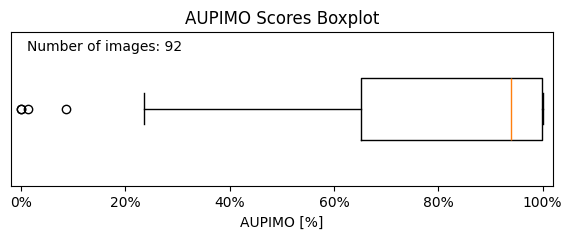

In [23]:
# fliers
#    if the distribution is very skewed to one side,
#    it is possible that some extreme values are considered
#    are considered as outliers, showing as fliers in the boxplot
#
#    there are two types of fliers: high and low
#    they are defined as:
#        - high: values > high whisker = Q3 + 1.5 * IQR
#        - low: values < low whisker = Q1 - 1.5 * IQR
#     where IQR = Q3 - Q1

# let's artificially simulate this situation
#     we will create a distortion in the values so that
#     high values (close to 1) become even higher
#     and low values (close to 0) become even lower


def distortion(vals: Tensor) -> Tensor:
    """Artificial distortion to simulate a skewed distribution.

    To visualize it:
    ```
    fig, ax = plt.subplots()
    t = np.linspace(0, 1, 100)
    ax.plot(t, np.clip(distortion(t), 0, 1), label="distortion")
    ax.plot(t, t, label="identity", linestyle="--")
    fig
    ```
    """
    return vals + 0.12 * (vals * (1 - vals) * 4)


mock = torch.clip(distortion(aupimo_result.aupimos.clone()), 0, 1)

fig, ax = plt.subplots(figsize=(7, 2))
ax.boxplot(
    mock[labels == 1].numpy(),
    vert=False,
    widths=0.4,
)
_ = ax.set_yticks([])
ax.set_xlim(0 - (eps := 2e-2), 1 + eps)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("AUPIMO [%]")
ax.set_title("AUPIMO Scores Boxplot")
num_images = (labels == 1).sum().item()
ax.annotate(
    text=f"Number of images: {num_images}",
    xy=(0.03, 0.95),
    xycoords="axes fraction",
    xytext=(0, 0),
    textcoords="offset points",
    annotation_clip=False,
    verticalalignment="top",
)
fig  # noqa: B018, RUF100

In [24]:
# `None` is the default policy, so the fliers are not returned
print(pd.DataFrame.from_records(boxplot_stats(mock, labels, flier_policy=None)))

  statistic  value  nearest  index  label
0    whislo   0.24     0.24     44      1
1        q1   0.65     0.65     58      1
2      mean   0.79     0.78     29      1
3       med   0.94     0.93     63      1
4        q3   1.00     1.00     22      1
5    whishi   1.00     1.00      0      1


In [25]:
# one can choose to include only high or low fliers, or both
# since there are only low fliers...

# 'low' and 'both' will return the same result
print("with option 'low'")
print(pd.DataFrame.from_records(boxplot_stats(mock, labels, flier_policy="low")))

print("with option 'both'")
print(pd.DataFrame.from_records(boxplot_stats(mock, labels, flier_policy="both")))

with option 'low'
  statistic  value  nearest  index  label
0   flierlo   0.00     0.00     65      1
1   flierlo   0.00     0.00     67      1
2   flierlo   0.01     0.01     71      1
3   flierlo   0.09     0.09     64      1
4    whislo   0.24     0.24     44      1
5        q1   0.65     0.65     58      1
6      mean   0.79     0.78     29      1
7       med   0.94     0.93     63      1
8        q3   1.00     1.00     22      1
9    whishi   1.00     1.00      0      1
with option 'both'
  statistic  value  nearest  index  label
0   flierlo   0.00     0.00     65      1
1   flierlo   0.00     0.00     67      1
2   flierlo   0.01     0.01     71      1
3   flierlo   0.09     0.09     64      1
4    whislo   0.24     0.24     44      1
5        q1   0.65     0.65     58      1
6      mean   0.79     0.78     29      1
7       med   0.94     0.93     63      1
8        q3   1.00     1.00     22      1
9    whishi   1.00     1.00      0      1


In [26]:
# and 'high' will return no fliers (same as `flier_policy=None` in this case)
print("with option 'high'")
print(pd.DataFrame.from_records(boxplot_stats(mock, labels, flier_policy="high")))

with option 'high'
  statistic  value  nearest  index  label
0    whislo   0.24     0.24     44      1
1        q1   0.65     0.65     58      1
2      mean   0.79     0.78     29      1
3       med   0.94     0.93     63      1
4        q3   1.00     1.00     22      1
5    whishi   1.00     1.00      0      1


## Other applications and `only_label` argument

In [27]:
# other applications
#    since the function is agnostic to the meaning of the values
#    we can also use it to find representative samples
#    with another metric or signal
#
#    in the last plot cell we used the maximum anomaly score per image
#    to select normal images, so let's reuse that criterion here

# recompute it for didactic purposes
max_anom_score_per_image = anomaly_maps.max(dim=2).values.max(dim=1).values  # noqa: PD011
print("stats for the maximum anomaly score in the anomaly maps")
print(pd.DataFrame.from_records(boxplot_stats(max_anom_score_per_image, labels)))
# notice that the indices are not the same as before

stats for the maximum anomaly score in the anomaly maps
  statistic  value  nearest  index  label
0    whislo   0.46     0.46     65      1
1        q1   0.63     0.63     48      1
2       med   0.70     0.71     10      1
3      mean   0.73     0.73    118      1
4        q3   0.81     0.81    115      1
5    whishi   1.00     1.00     22      1


In [28]:
# we can also use the `only_label` argument to select only the
# samples from the normal class
print(pd.DataFrame.from_records(boxplot_stats(max_anom_score_per_image, labels, only_label=0)))
# notice the labels are all 0 now

  statistic  value  nearest  index  label
0    whislo   0.42     0.42     90      0
1        q1   0.43     0.43     80      0
2       med   0.45     0.45    105      0
3      mean   0.46     0.46     89      0
4        q3   0.48     0.48     75      0
5    whishi   0.52     0.52     95      0


In [29]:
# or we can consider data from both classes (`None` option)
print(pd.DataFrame.from_records(boxplot_stats(max_anom_score_per_image, labels, only_label=None)))
# notice that the labels are mixed

  statistic  value  nearest  index  label
0    whislo   0.42     0.42     90      0
1        q1   0.52     0.52     95      0
2       med   0.65     0.65     17      1
3      mean   0.66     0.66     45      1
4        q3   0.77     0.77    108      1
5    whishi   1.00     1.00     22      1


# Cite Us

AUPIMO was developed during Google Summer of Code 2023 (GSoC 2023) with the `anomalib` team from OpenVINO Toolkit.

Our work was accepted to the British Machine Vision Conference 2024 (BMVC 2024).

```bibtex
@misc{bertoldo2024aupimo,
      title={{AUPIMO: Redefining Visual Anomaly Detection Benchmarks with High Speed and Low Tolerance}}, 
      author={Joao P. C. Bertoldo and Dick Ameln and Ashwin Vaidya and Samet Akçay},
      year={2024},
      eprint={2401.01984},
      archivePrefix={arXiv},
      primaryClass={cs.CV},
      url={https://arxiv.org/abs/2401.01984}, 
}
```

Paper on arXiv: [arxiv.org/abs/2401.01984](https://arxiv.org/abs/2401.01984) (accepted to BMVC 2024)

Medium post: [medium.com/p/c653ac30e802](https://medium.com/p/c653ac30e802)

Official repository: [github.com/jpcbertoldo/aupimo](https://github.com/jpcbertoldo/aupimo) (numpy-only API and numba-accelerated versions available)

GSoC 2023 page: [summerofcode.withgoogle.com/archive/2023/projects/SPMopugd](https://summerofcode.withgoogle.com/archive/2023/projects/SPMopugd)